In [105]:
from data_loader import kline_api
from data_loader.generate_columns import generate, Data, Coinmarket
from datetime import datetime, timezone, timedelta
import time
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler

In [2]:
"""
    Check if the coin pair exists in the database
"""
def query_coin(coin, market):
    query = Coinmarket.select().where(Coinmarket.coin == coin, Coinmarket.market == market)
    try:
        return query[0]
    except IndexError:
        # Coin doesn't exist
        return False

"""
    Returns all saved candles for the coin pair
    coin: str
    market: str
    limit: int
    start_date: big int
    end_date: big int
"""
def query_candles(coin, market, limit=None, start_date=None, end_date=None):
    query = query_coin(coin, market)
    if(query != False):
        if(limit == None):
            if(isinstance(start_date, str)):
                start_date = convert(start_date)
            if(isinstance(end_date, str)):
                end_date = convert(end_date)
                # return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            if(start_date == None and end_date != None):
                return Data.select().where(Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date == None):
                return Data.select().where(Data.timestamp >= start_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date != None):
                return Data.select().where(Data.timestamp >= start_date, Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date == None and end_date == None):
                return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
        else:
            return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc()).limit(limit)
    else:
        return False

In [3]:

"""
    Converts the candles to a higher time frame since all current candles are in 1m denominations
    coin: str
    market: str
    interval: str (1m, 15m, 30m, 60m, 1h, 2h, 4h)
"""
def convertCandles(coin, market, interval):

    def splitInterval(interval):
        res = re.findall('(\d+|[A-Za-z]+)', interval)
        return int(res[0]), res[1]

    interval_num, interval_type = splitInterval(interval)

    t = 1648706280000
    ts = datetime.fromtimestamp(int(t/1000))


    pretend_data = query_candles(coin, market)
    
    if not pretend_data:
        print("[ERROR] Coin pair not found")
        return

    candle_array = []
    candle = {
      "high": [],
      "low": [],
      "close": 0,
      "BV": 0, # BTC Vol
      "V": 0, # Assets traded
    }

    current_count = {interval_type: 0}
    for value in range(1, len(pretend_data)):
        cur_time = datetime.fromtimestamp(int(pretend_data[value - 1].timestamp/1000))
        next_time = datetime.fromtimestamp(int(pretend_data[value].timestamp/1000))
        i = pretend_data[value-1]
        # PUT STUFF IN CANDLE DICT
        if("open" not in candle and "timestamp" not in candle):
            candle["open"] = float(i.open)
            candle['timestamp'] = i.timestamp

        candle['low'].append(float(i.low))
        candle['high'].append(float(i.high))
        candle['BV'] += float(i.shares)
        candle['V'] += float(i.btc_vol)
        if(interval_type == "h"):
            if(cur_time.hour != next_time.hour):
                current_count[interval_type] += 1
                if((cur_time.hour + 1) % interval_num == 0):
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0
        elif(interval_type == "m"):
            if(cur_time.minute != next_time):
                current_count[interval_type] += 1
                if((cur_time.minute + 1) % interval_num == 0):
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0
    candle_array = candle_array[1:]
    return candle_array

In [4]:
SEQ_LEN = 24

"""
    Generates windows of candles of size 24
"""

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [230]:
"""
    Convert the candles to a higher timeframe
"""

m30 = convertCandles("XMR", "USDT", "30m")
h4 = convertCandles("XMR", "USDT", "4h")

In [149]:
"""
    Convert candles into a pandas dataframe
"""

prices = pd.DataFrame({'open': [i['open'] for i in h4],
                       'close': [i['close'] for i in h4],
                       'high': [i['high'] for i in h4],
                       'low': [i['low'] for i in h4]},
                       index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4])

In [7]:
X_train, y_train, X_test, y_test =\
 preprocess(prices, SEQ_LEN, train_split = 0.95)

In [294]:
def calculate_slopes(data, length):
    LENGTH = length
    slope_array = []
    intercept_array = []
    for i in range(LENGTH, len(data)):
        slope, intercept, r, p, std_err = stats.linregress([int(i) for i in range(LENGTH)], [float(i['close']) for i in data[i-LENGTH:i]])
        slope_array.append(slope)
        intercept_array.append(intercept)

#     print(len(data[LENGTH:]))
#     print(len(data))
#     print(len(slope_array))
    prices = pd.DataFrame({
#                             'open': [i['open'] for i in data[LENGTH:]],
#                            'close': [i['close'] for i in data[LENGTH:]],
#                            'high': [i['high'] for i in data[LENGTH:]],
#                            'low': [i['low'] for i in data[LENGTH:]],
                           'slope' : slope_array},
#                            'intercept': intercept_array},
                           index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in data[LENGTH:]])
    return prices

In [391]:
len(h4)

2246

In [359]:
START, END = 0, 36 # WINDOW SIZE, increment start and end by 1 loop and recalculate each window

hour4 = calculate_slopes(h4, 12)
minute30 = calculate_slopes(m30, 12)

In [360]:
### Take the highest timeframe
print(f"[4h]: {hour4.size} candles")
print(f"[30m]: {minute30.size} candles")

[4h]: 2234 candles
[30m]: 17985 candles


In [361]:
print(f"----------- [4h] Size: {hour4.size} -----------")
print(f"Start: {hour4.index[0]}")
print(f"End: {hour4.index[-1]}")

print()
print(f"----------- [30m] Size: {minute30.size} -----------")
print(f"Start: {minute30.index[0]}")
print(f"End: {minute30.index[-1]}")

----------- [4h] Size: 2234 -----------
Start: 2020-04-01 20:00:00
End: 2021-04-09 12:00:00

----------- [30m] Size: 17985 -----------
Start: 2020-03-31 00:00:00
End: 2021-04-09 17:00:00


In [362]:
minute30Candles = minute30[(minute30.index <= hour4.index[-1]) & (hour4.index[0] <= minute30.index)]

print("----------- [30m] -----------")
print(f"Start: {minute30Candles.index[0]}")
print(f"End: {minute30Candles.index[-1]}")

----------- [30m] -----------
Start: 2020-04-01 20:00:00
End: 2021-04-09 12:00:00


In [389]:
hour4.shape

(2234, 1)

In [402]:
x1 = hour4.values #returns a numpy array
scaler4h = MinMaxScaler()
x_scaled4h = scaler4h.fit_transform(x1)
df4 = pd.DataFrame(x_scaled4h, index=hour4.index)

In [403]:
x2 = minute30.values #returns a numpy array
scaler30m = MinMaxScaler()
x_scaled30m = scaler30m.fit_transform(x2)
df30 = pd.DataFrame(x_scaled30m, index=minute30.index)

In [404]:
print(df4.head())

                            0
2020-04-01 20:00:00  0.514971
2020-04-02 00:00:00  0.520599
2020-04-02 04:00:00  0.526090
2020-04-02 08:00:00  0.531460
2020-04-02 12:00:00  0.537931


In [405]:
df30.head()

,0
2020-03-31 00:00:00,0.530658
2020-03-31 00:30:00,0.533827
2020-03-31 01:00:00,0.536656
2020-03-31 01:30:00,0.540386
2020-03-31 02:00:00,0.542056


In [507]:
def getSlopes(window):
#     print(window.head())
    slopes = window[0]
    X_train = slopes[0:24].to_numpy()
    Y_train = slopes[35]
    
    return X_train, Y_train

def combine_timeframe(t1, t2):
    X_train1, Y_train1 = getSlopes(t1)
    X_train2, Y_train2 = getSlopes(t2)
    
    comb_X_train = np.array([X_train1, X_train2])
    comb_Y_train = np.array(Y_train1)
    
    return comb_X_train, comb_Y_train


In [508]:
df4.shape

(2234, 1)

In [509]:


X = []
Y = []
for i in range(0, 2000):

    START, END = 0 + i, 36 + i # WINDOW SIZE, increment start and end by 1 loop and recalculate each window
    try:
        hour4Candles = df4[START:END]
        minute30Candles = df30[df30.index <= df4.index[END - 1]].tail(END)
    except Exception as e:
        print(e, END)

    X_train, Y_train = combine_timeframe(minute30Candles, hour4Candles)
    
    X.append(X_train)
    Y.append(Y_train)

X_train = np.array(X)
Y_train = np.array(Y)
# print(Y_train)

# scaler = MinMaxScaler()

# n = scaler.fit_transform(Y_train)


In [522]:
print(X_train.shape)
print(Y_train.shape)

Y_train[0]

(2000, 2, 24)
(2000,)


0.47808337602459017

In [512]:
X_te = []
Y_te = []
for i in range(2000,2180):

    START, END = 0 + i, 36 + i # WINDOW SIZE, increment start and end by 1 loop and recalculate each window
    
    try:
        hour4Candles = df4[START:END]
        minute30Candles = df30[df30.index <= df4.index[END - 1]].tail(END)
    except Exception as e:
        print(e, END)

    X_test, Y_test = combine_timeframe(minute30Candles, hour4Candles)
    
    X_te.append(X_test)
    Y_te.append(Y_test)

X_test = np.array(X_te)
Y_test = np.array(Y_te)

print(X_test.shape)
print(Y_test.shape)

(180, 2, 24)
(180,)


In [523]:
Y_test[0]

0.553129269125683

In [524]:
import keras
import tensorflow
from keras.layers import Bidirectional, CuDNNLSTM, Dropout, Dense, Activation, LSTM
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(
  LSTM(8, return_sequences=True,
  input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(rate=DROPOUT))

model.add(
  LSTM(16, return_sequences=True)
)
model.add(Dropout(rate=DROPOUT))

model.add(
  LSTM(32, return_sequences=True)
)

model.add(Dense(units=1))

# model.add(Activation('linear'))

In [525]:
BATCH_SIZE = 100

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/10


2022-04-24 14:43:03.346738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:03.612720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:03.738479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:03.840121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:03.970818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:04.187454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:04.430923: I tensorflow/core/grappler/optimizers/cust

17/18 [===========================>..] - ETA: 0s - loss: 0.2295

2022-04-24 14:43:05.662826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:05.763824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:05.850540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 5s 83ms/step - loss: 0.2266 - val_loss: 0.1721
Epoch 2/10
 1/18 [>.............................] - ETA: 0s - loss: 0.1695

2022-04-24 14:43:05.949622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 16ms/step - loss: 0.1111 - val_loss: 0.0578
Epoch 3/10
18/18 [==============================] - 0s 15ms/step - loss: 0.0505 - val_loss: 0.0475
Epoch 4/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0403 - val_loss: 0.0401
Epoch 5/10
18/18 [==============================] - 0s 15ms/step - loss: 0.0332 - val_loss: 0.0329
Epoch 6/10
18/18 [==============================] - 0s 18ms/step - loss: 0.0253 - val_loss: 0.0253
Epoch 7/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0176 - val_loss: 0.0173
Epoch 8/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 9/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0047 - val_loss: 0.0070
Epoch 10/10
18/18 [==============================] - 0s 15ms/step - loss: 0.0035 - val_loss: 0.0069


In [526]:
y_hat = model.predict(X_test)
print(y_hat.shape)

2022-04-24 14:43:10.952859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:11.047239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:11.137268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:43:11.225582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(180, 2, 1)


In [527]:
Y_test.shape

# plt.plot(Y_test)


(180,)

In [528]:
y_hat[0]

array([[0.51246876],
       [0.51638883]], dtype=float32)

In [521]:
for i in range(20,100):
    print(Y_test[i], y_hat[i])

0.4370624146174864 [[0.50660604]
 [0.5185125 ]]
0.5523821721311475 [[0.50785035]
 [0.5200953 ]]
0.5277813353825136 [[0.5040824]
 [0.5228037]]
0.6339598275273224 [[0.51008666]
 [0.52373064]]
0.6122940146857923 [[0.5128158 ]
 [0.52521485]]
0.49276916837431683 [[0.52199936]
 [0.5258854 ]]
0.5055872182377049 [[0.5319904 ]
 [0.52608424]]
0.5881521089480873 [[0.5273272 ]
 [0.52838707]]
0.4545338114754099 [[0.52153313]
 [0.52798426]]
0.5622171704234973 [[0.5178623]
 [0.528313 ]]
0.6566982581967216 [[0.51365536]
 [0.53004396]]
0.5784611936475406 [[0.51534104]
 [0.5290787 ]]
0.4097773650956285 [[0.52427053]
 [0.5270574 ]]
0.5203957479508197 [[0.529372 ]
 [0.5273752]]
0.5275038422131146 [[0.5230211 ]
 [0.52696985]]
0.4799351092896176 [[0.5134519]
 [0.5265167]]
0.5309564976092894 [[0.5090355]
 [0.5266165]]
0.48809981215847 [[0.5081924]
 [0.5273826]]
0.5166602629781419 [[0.51185197]
 [0.5260788 ]]
0.5587698514344264 [[0.5106806 ]
 [0.52550346]]
0.5431341786202184 [[0.50941277]
 [0.5249318 ]]
0.506

-0.004432877146760382 -0.00096010650907244


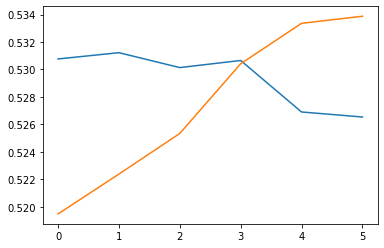

0.014749981703747153 -0.0009439008576529366


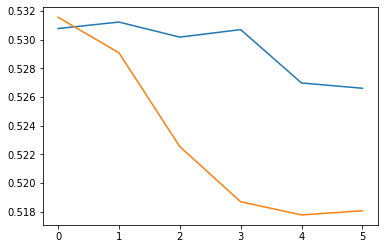

-0.011906743998829107 -0.0009764654295785087


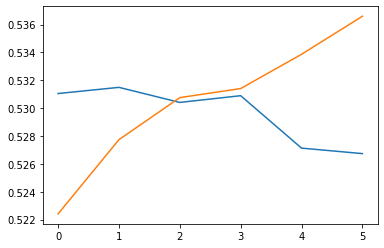

0.002955912129196006 -0.0009497949055262974


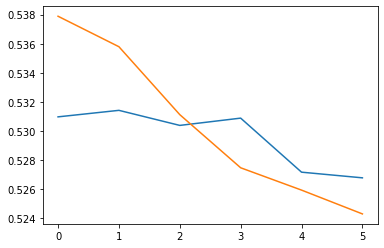

-0.0065814671155347785 -0.000946925367627825


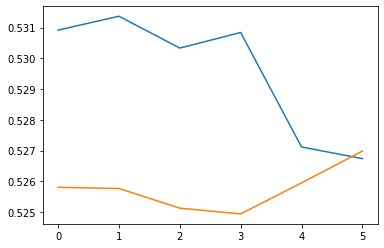

0.008834955601092917 -0.0009263362203325544


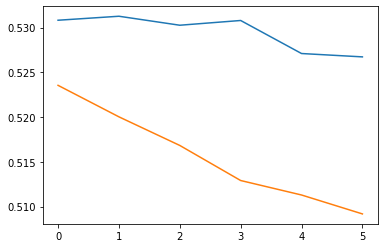

0.009510392271662742 -0.0009391461099897112


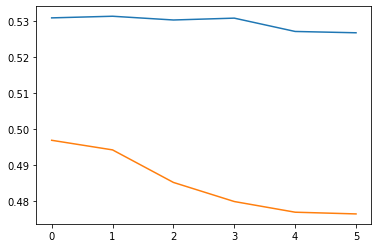

-0.01834123121584697 -0.0009608660425458635


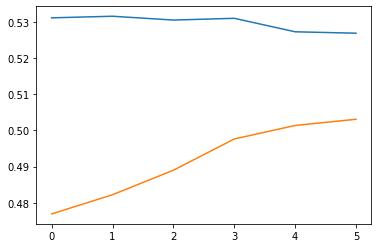

0.0131676607630757 -0.000924607685634068


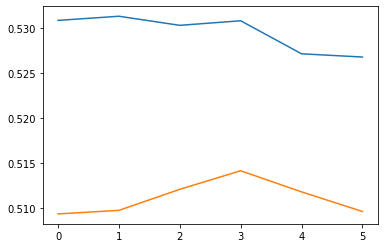

-0.004465810402029618 -0.0009433116231645856


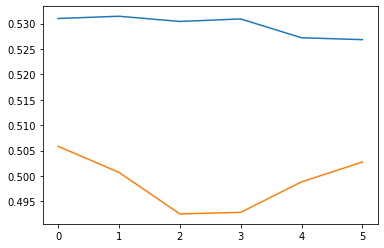

In [445]:
# plt.plot(y_hat[99])
# plt.plot(Y_train[99])


for i in range(10,20):
    y_hat_slope, y_hat_intercept, r, p, std_err = stats.linregress([int(i) for i in range(y_hat.shape[1])], y_hat[i])
    Y_test_slope, Y_test_intercept, r, p, std_err = stats.linregress([int(i) for i in range(Y_test.shape[1])], Y_test[i])
    
    print(Y_test_slope, y_hat_slope)
    plt.plot(y_hat[i])
    plt.plot(Y_train[i])
    
    plt.show()

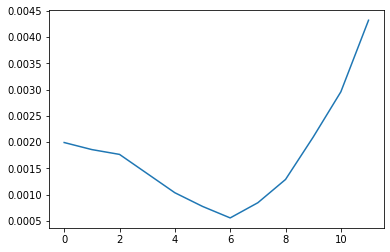

In [331]:
plt.plot(Y_train[2])

In [520]:
y_test_inverse = scaler30m.inverse_transform(Y_test.reshape(-1,1))
y_hat_inverse = scaler30m.inverse_transform(y_hat)

print(y_test_inverse.shape)
print(y_hat_inverse.shape)
plt.plot(y_test_inverse)

ValueError: Found array with dim 3. Estimator expected <= 2.

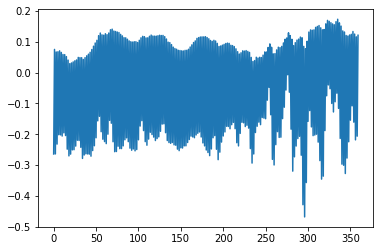

In [503]:
# plt.plot(y_test_inverse)
plt.plot(y_hat_inverse)

-0.0408801198801199 -0.006123750337532588


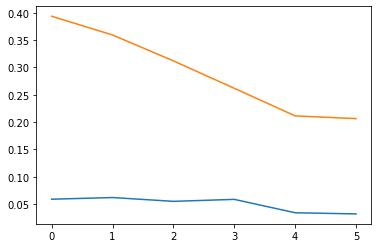

0.016184815184815012 -0.00619897906269346
-0.04083516483516475 -0.0061640316886561256


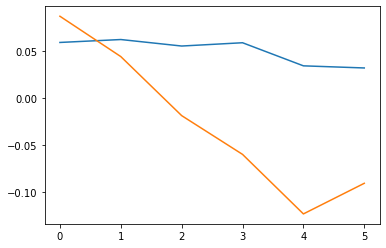

0.10255044955044947 -0.006069911590644291
-0.07465634365634365 -0.006295107411486762


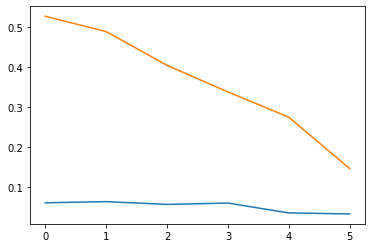

-0.04421978021978025 -0.00628419497183391


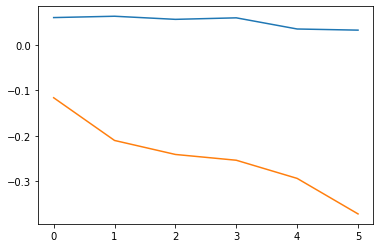

0.023439560439560428 -0.006046311557292939
0.033838161838161705 -0.006025780524526324
-0.04899900099900085 -0.006322802496807916


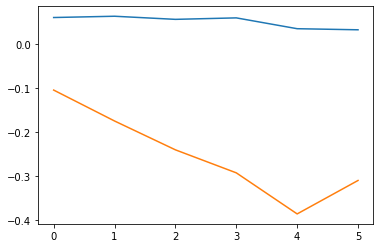

0.007596403596403858 -0.006194024745907102
-0.0290449550449553 -0.006290778411286218


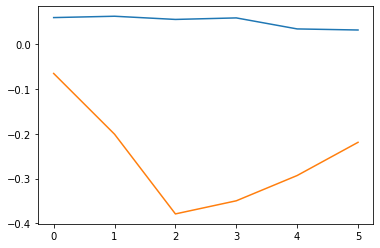

0.09664435564435618 -0.006184596036161696
-0.07801498501498545 -0.0063979649118014745


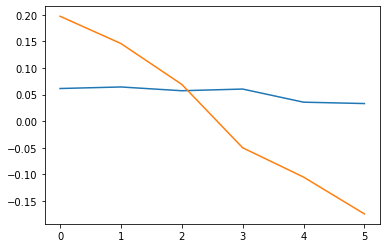

0.0193676323676328 -0.006223215056317194
-0.043122877122877386 -0.006204413303307124


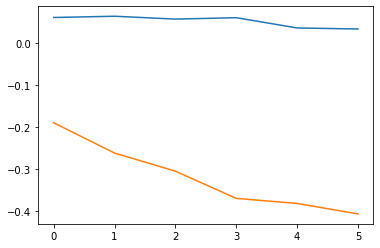

0.057888111888112034 -0.006069510323660714
0.06231368631368617 -0.006153442391327449
-0.120174825174825 -0.006295755079814366


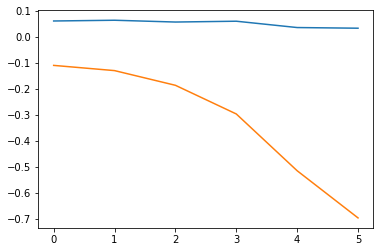

0.08627672327672312 -0.006058184483221599
-0.029260739260738952 -0.0061807352517332355


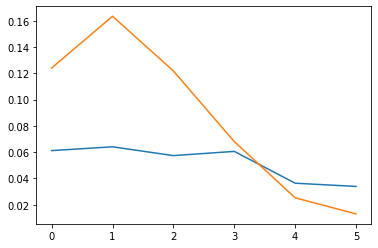

-0.06147652347652352 -0.006209601887634823


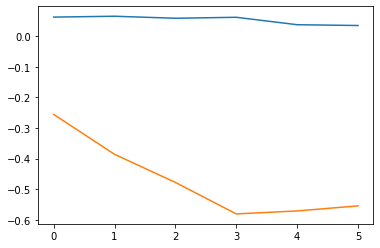

0.0908541458541457 -0.005918693861791066
-0.041202797202797015 -0.006091826409101487


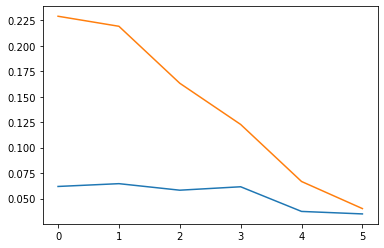

0.11556143856143855 -0.006053196425948823
-0.09441458541458539 -0.006148219747202736


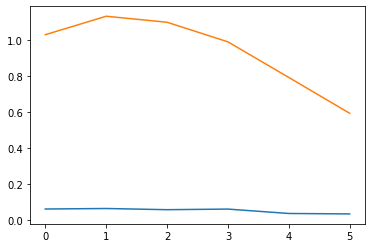

-0.049847152847152854 -0.006206053814717702


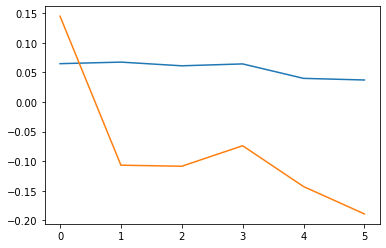

0.004677322677322693 -0.0057402176516396656
0.0673116883116882 -0.00565423241683415
-0.12834965034965018 -0.005963706757341112


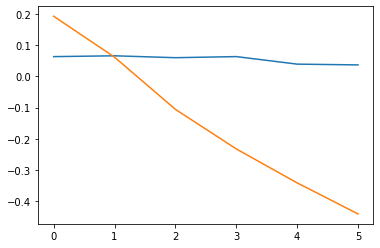

0.12781918081918073 -0.005672397996698107
0.06554645354645405 -0.005824786424636841
-0.06047252747252806 -0.006208831497601101


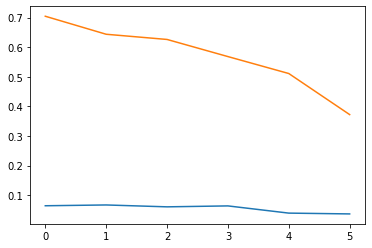

-0.17668531468531448 -0.006099524774721691


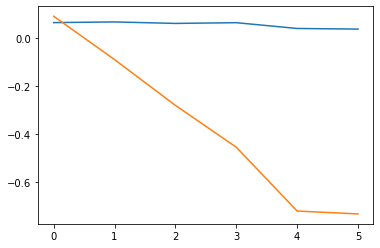

0.10816083916083899 -0.005589782233749117
-0.013171828171828399 -0.005806542826550348


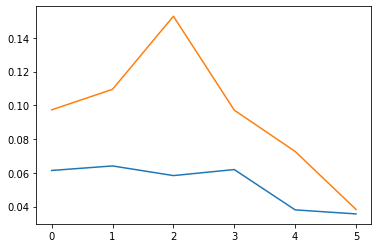

-0.05118181818181799 -0.005960827746561596


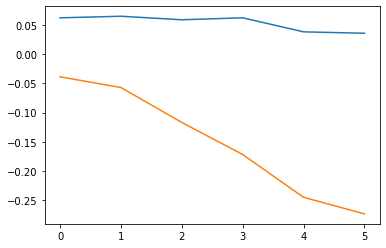

0.0671358641358639 -0.005830465789352144
-0.08163336663336647 -0.005894759829555239


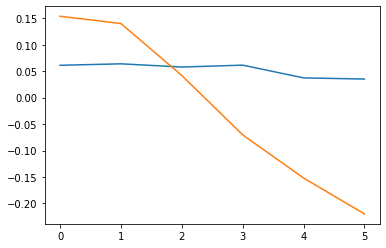

0.04288611388611375 -0.005863640031644276
0.01214785214785238 -0.005868191484894072
-0.015892107892108254 -0.006000016097511564


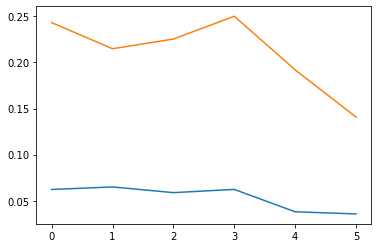

-0.039845154845154475 -0.006073672217982155


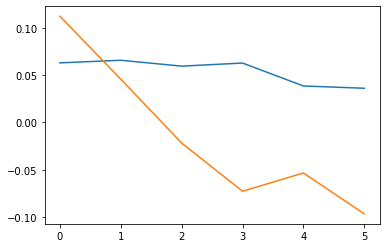

0.014239760239760079 -0.005964041394846779
-0.00020279720279693935 -0.005972444159643991


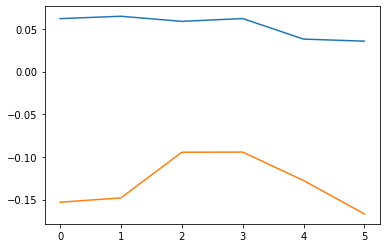

0.05592507492507483 -0.005996970087289811
-0.08927172827172836 -0.006090464868715831


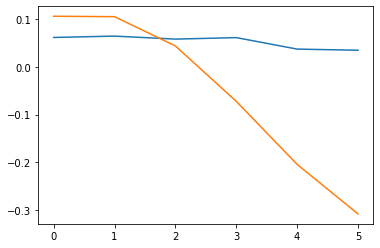

0.010057942057942186 -0.006036737667662757
0.08090209790209754 -0.005959756353071758
0.017773226773226864 -0.006188601468290602
-0.023422577422577136 -0.006266710055725915


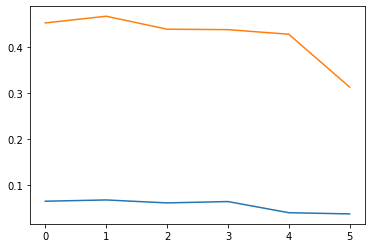

0.032638361638361535 -0.006146556990487235
-0.10092407592407575 -0.006029886326619557


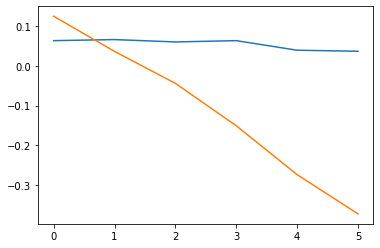

0.04815384615384609 -0.005760302607502256
0.027075924075924098 -0.005763393214770726
0.0005094905094904052 -0.005820802386317934
-0.06668631368631343 -0.00589657894202641


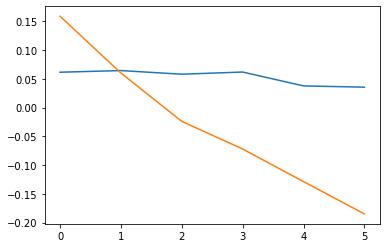

0.047280719280719245 -0.005607679805585316
-0.038103896103896 -0.005741322572742189


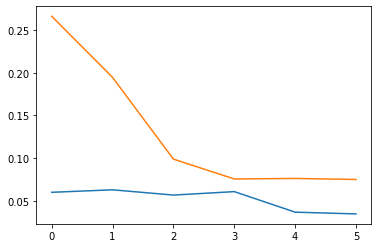

0.01603696303696334 -0.005751019184078489
0.05848451548451517 -0.0056953619633402135
0.0029240759240760183 -0.005881068749087197
0.03627972027972031 -0.005942127002137048
-0.021801198801198837 -0.0061111861041613985


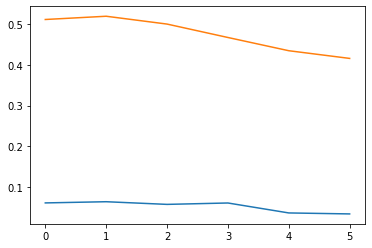

-0.03967632367632364 -0.006230836042336056


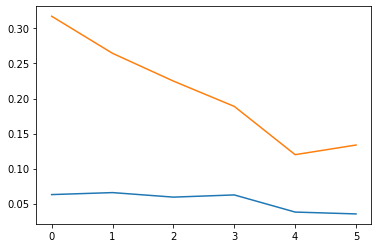

-0.030012987012987172 -0.006158530818564551


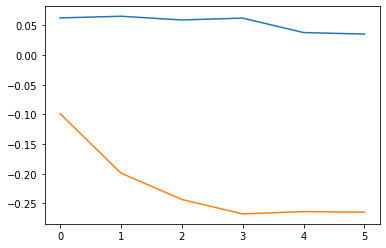

0.08412987012987048 -0.006017567749534334
-0.05413986013986064 -0.006232476766620363


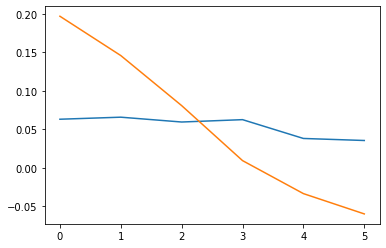

-0.011549450549450422 -0.0062109738588333125


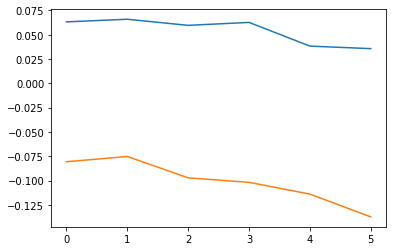

0.08948951048951037 -0.006151255326611655
-0.12665034965034946 -0.006224386606897627


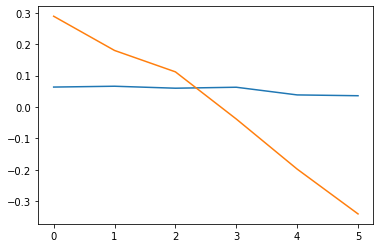

0.1087332667332665 -0.00610629820397922
-0.04400299700299702 -0.006107113297496523


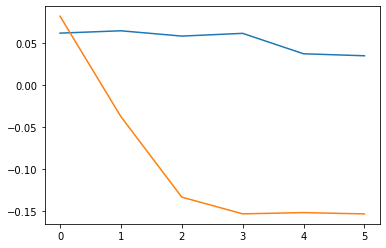

0.05729970029970033 -0.006028157259736742
0.052076923076923055 -0.006073091604879924
0.01725274725274753 -0.00593571098787444
-0.038519480519480724 -0.006015001663139888


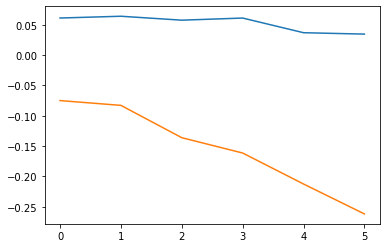

0.0871688311688313 -0.005871450368847166
-0.002424575424575501 -0.005962814816406795


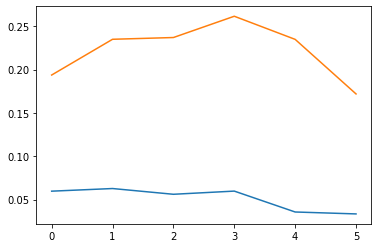

-0.04491308691308684 -0.006064153994832721


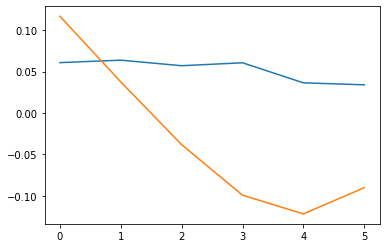

0.07887912087912112 -0.005975869404418128
-0.07139660339660324 -0.00609123483300209


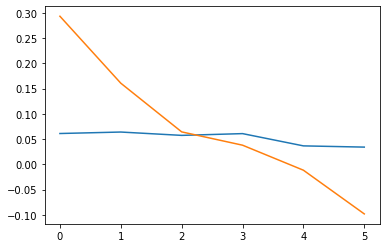

0.06485114885114876 -0.005983423015901021
0.018493506493506416 -0.005992227579866136
-0.0631078921078921 -0.0061054618230887816


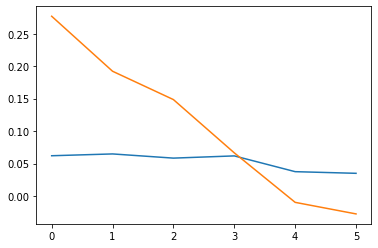

0.027409590409590248 -0.006016596938882555
-0.06690609390609391 -0.006043332602296557


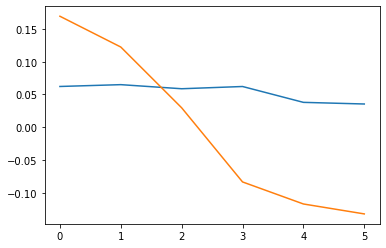

0.011170829170829072 -0.005955315381288529
-0.023419580419580567 -0.005905371904373169


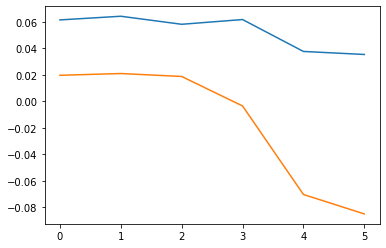

0.011925074925074598 -0.005890531305755887
-0.029107892107891893 -0.005827219039201736


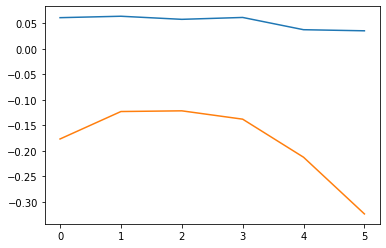

0.03648251748251748 -0.005783846867935999
0.0710649350649348 -0.005794647655316762
-0.11170229770229764 -0.006107815567936216


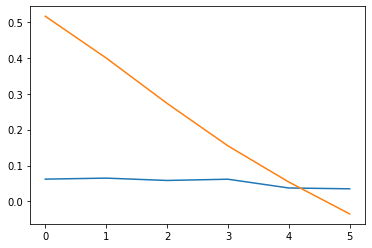

-0.06895804195804234 -0.005999357146876198


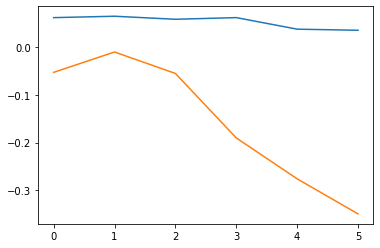

0.0012957042957041603 -0.00578879000885146
0.05772527472527482 -0.00568946972489357
-0.04062137862137859 -0.0060101927391120365


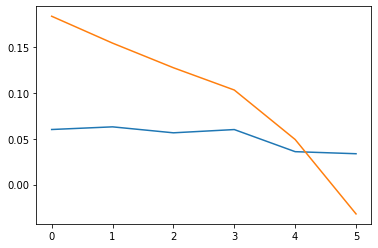

0.08814385614385617 -0.006022153794765473
-0.05651348651348665 -0.006005382750715528


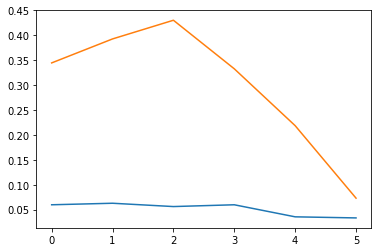

0.11538461538461553 -0.006019487444843564
-0.09453046953046926 -0.00607386188847678


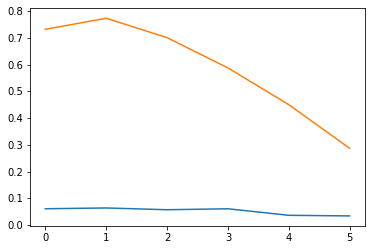

-0.010590409590409714 -0.006061576093946184


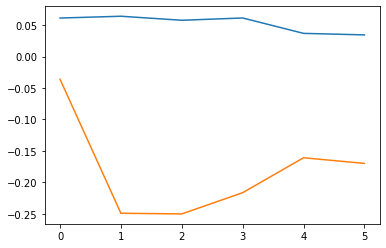

0.13332067932067945 -0.005799702661378043
-0.13134465534465548 -0.0060963006956236705


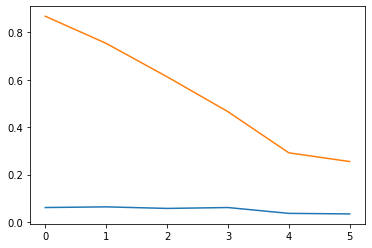

0.021598401598401856 -0.00608805449945586
-0.0539280719280718 -0.005953206866979598


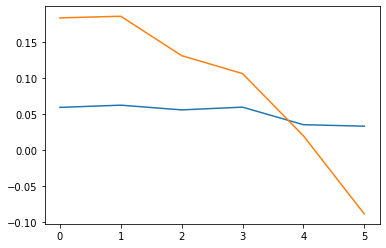

-0.02526073926073945 -0.0059423718069280896


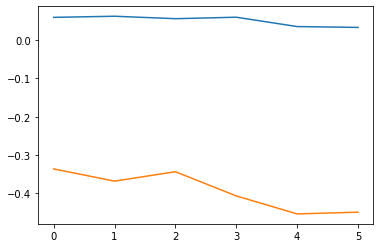

0.1387452547452547 -0.005907804306064333
-0.08247152847152832 -0.0063382231763431


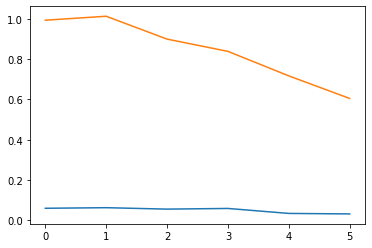

-0.04132067932067948 -0.006556512096098492


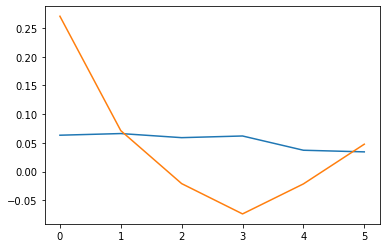

0.09358341658341696 -0.006216140517166683
-0.04446653346653394 -0.00630596461040633


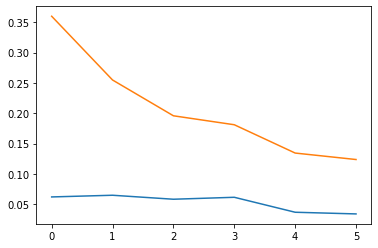

0.1455444555444556 -0.006257024726697377
-0.2590009990009989 -0.006417357176542283


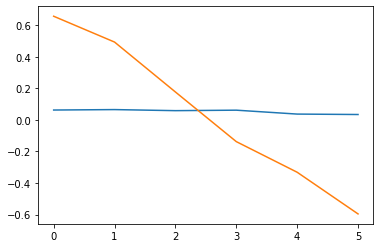

0.12714685314685312 -0.0060321739741734095
0.09465034965034974 -0.00574184741292681
0.04908791208791199 -0.006090799293347767
-0.08221378621378604 -0.00645284088594573


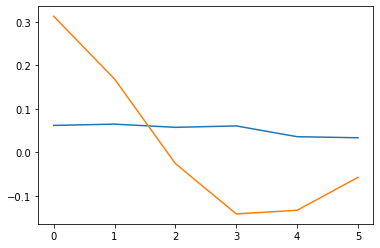

0.007042957042956993 -0.006100206077098847
-0.030525474525474643 -0.006314879655838013


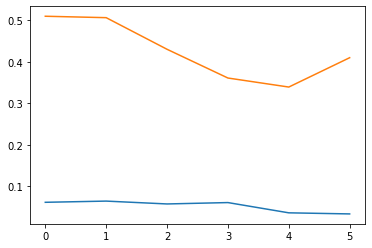

0.03164535464535474 -0.006351713091135025
0.0745814185814187 -0.006315326477800096
-0.2084165834165836 -0.006511756884200233


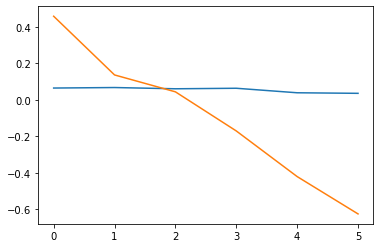

0.4152967032967036 -0.006039002644164222
-0.22030869130869118 -0.0066627277859619685


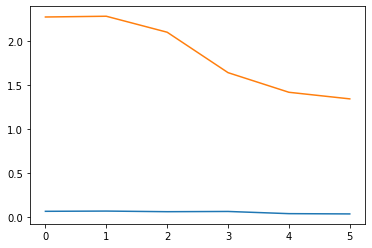

-0.15220579420579425 -0.006726855358907155


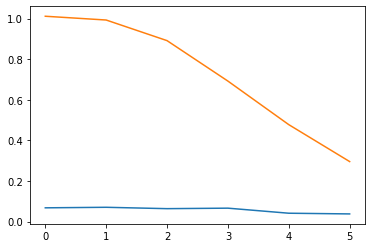

-0.10647152847152833 -0.006294449312346322


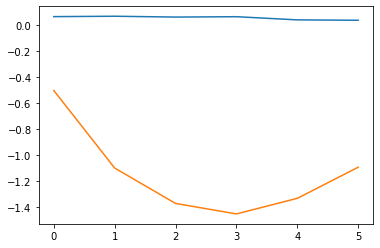

0.12080319680319676 -0.005369116153035845
0.12485314685314662 -0.005837127353463855
-0.0867452547452544 -0.006243947254759925


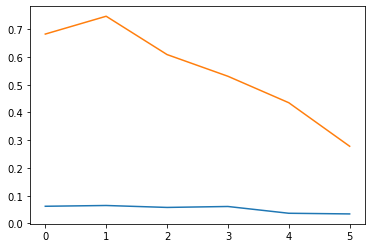

-0.0456593406593407 -0.006236739030906132


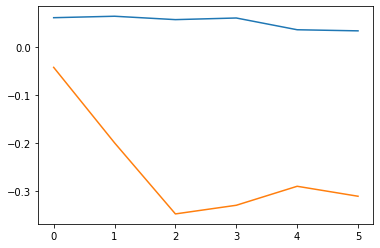

0.10351848151848163 -0.005898017649139677
0.006733266733266518 -0.006064287679536002
0.07410889110889139 -0.006214566954544612
-0.12394705294705312 -0.0065148699496473585


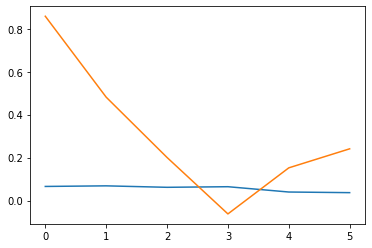

0.41868431568431574 -0.0061745197645255495
-0.5570519480519479 -0.00694395016346659


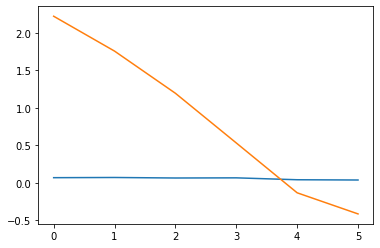

-0.13232867132867154 -0.006189962795802525


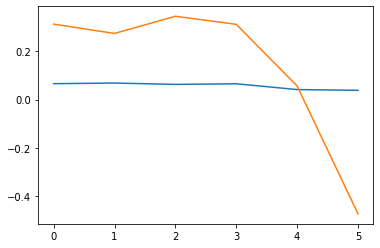

0.0561598401598403 -0.005976795511586325
0.0367122877122875 -0.005588799608605249
0.13255844155844176 -0.006131750132356372
-0.20050449550449542 -0.0063429099108491625


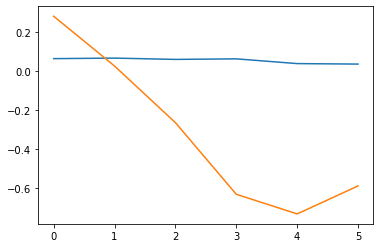

0.1273226773226773 -0.005869162934167045
0.07122377622377606 -0.006090598766292844
-0.53815984015984 -0.0060833455196448736


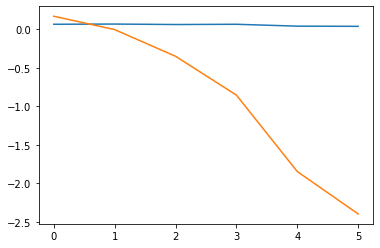

0.07082217782217783 -0.005201552169663565
0.36238661338661315 -0.004560532261218344
-0.2216773226773226 -0.006363730771200997


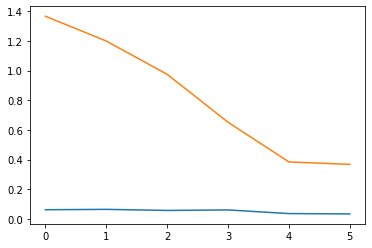

0.05083516483516444 -0.006384998134204319
-0.041653346653346926 -0.006078905505793436


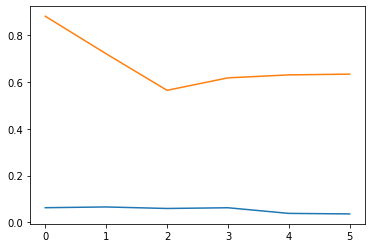

0.04407292707292724 -0.006143444563661303
0.1365764235764232 -0.005843766991581235
-0.03907292707292705 -0.006029038556984493


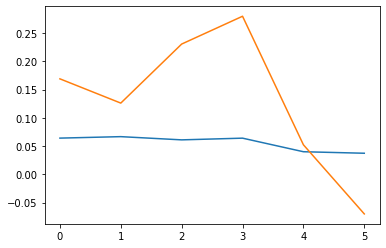

0.1544015984015983 -0.005946322849818638
-0.23333366633366648 -0.006007860068764005


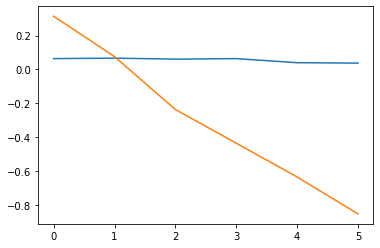

0.05626173826173837 -0.005596901263509478
0.05500299700299681 -0.0053510953273092
0.15047652347652354 -0.005388821235724857
0.14965434565434574 -0.0059784471988677985
-0.08063036963036993 -0.006319053364651544


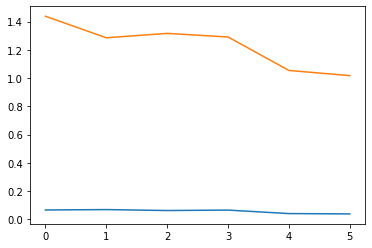

-0.012204795204795085 -0.006134495032685144


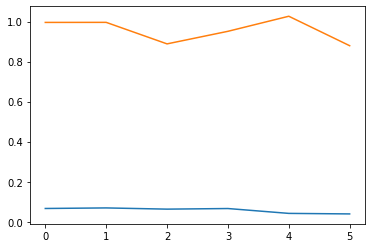

-0.0630859140859143 -0.006089171022176743


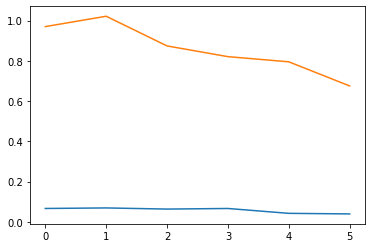

-0.12602197802197795 -0.006075088679790497


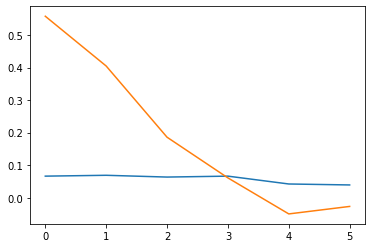

0.26094305694305714 -0.005858751918588366
-0.02526273726273751 -0.006224978076560157


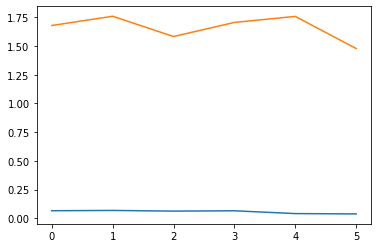

-0.29312887112887065 -0.006457984766789845


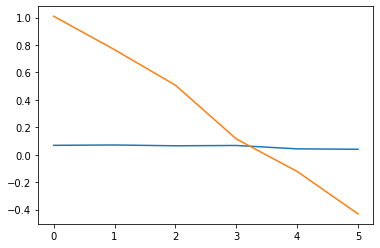

0.14682617382617394 -0.005901990511587688
-0.15320779220779207 -0.005862133843558176


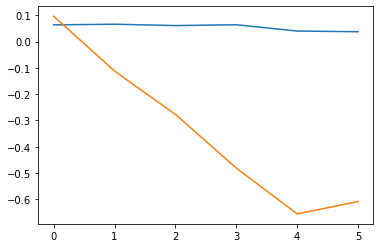

0.06194405594405627 -0.005699579204831805
-0.041759240759240514 -0.005656987854412624


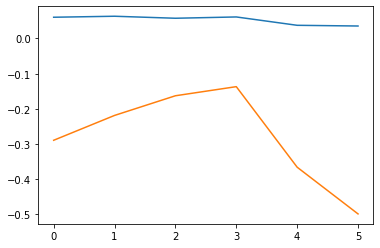

0.11942957042957014 -0.005636010638305119
0.1340459540459544 -0.005596209317445754
-0.014695304695305063 -0.006138780606644494


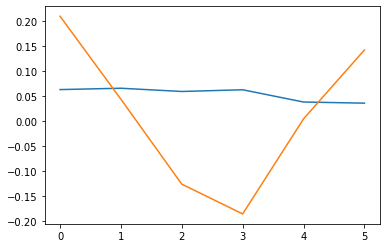

0.18409990009989965 -0.005949156944240842
-0.19040959040959052 -0.006307414812701089


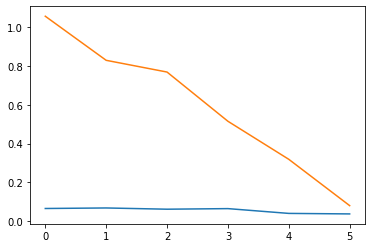

-0.16244955044955084 -0.006013696321419307


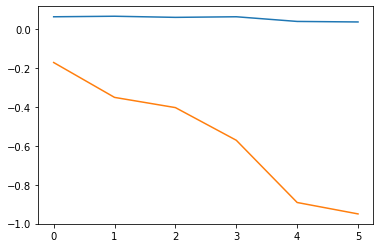

0.2774675324675328 -0.005491321640355247
-0.028001998001998492 -0.00600858490381922


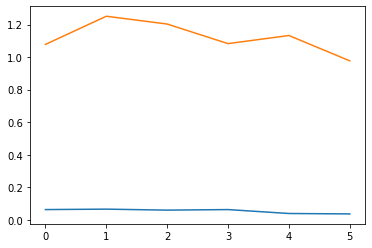

-0.06019380619380633 -0.006435713278395788


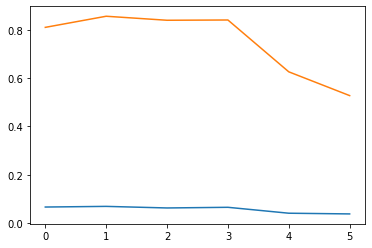

-0.1982327672327668 -0.0062800668179988865


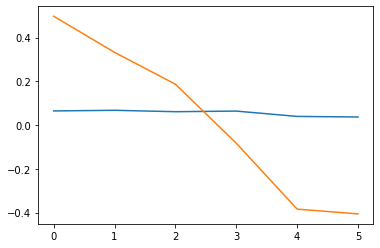

-0.02325874125874086 -0.005826939748866218


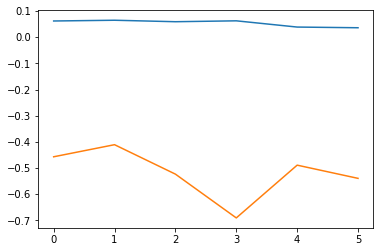

0.10025474525474458 -0.0056949933724743974
-0.2916583416583413 -0.005882039772612708


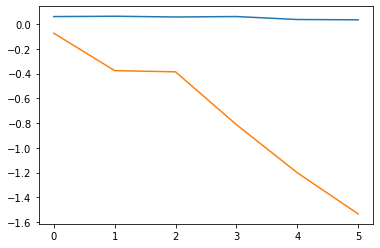

0.2287212787212785 -0.00544624137026923
-0.2590589410589404 -0.005657557185207094


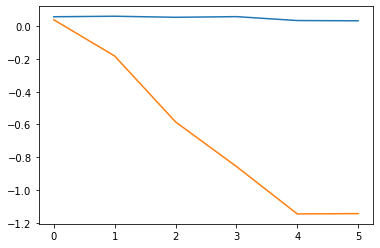

0.23236963036963032 -0.005557277692215782
-0.06628271728271734 -0.005861139829669681


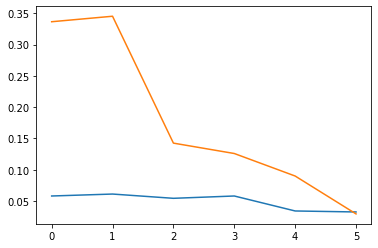

-0.06398501498501467 -0.00594503932765552


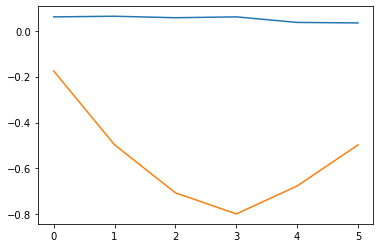

0.15558541458541442 -0.005719854150499617
0.1320759240759236 -0.0059548137443406245
-0.07488811188811108 -0.006070401838847568


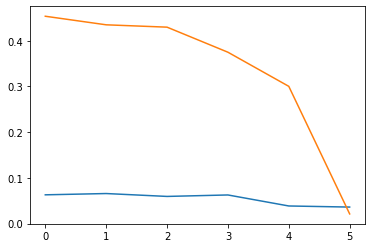

-0.0603176823176831 -0.006066475702183587


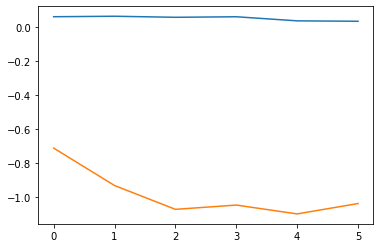

0.16067732267732315 -0.005439970855201993
0.05328871128871129 -0.005572085295404707
-0.061093906093906344 -0.005652893121753421


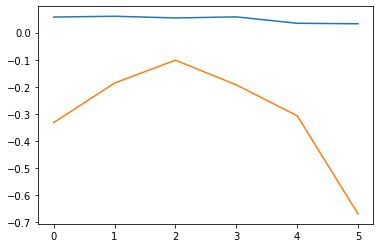

0.010407592407592748 -0.005615858627217156
-0.019113886113885956 -0.005238999319928033


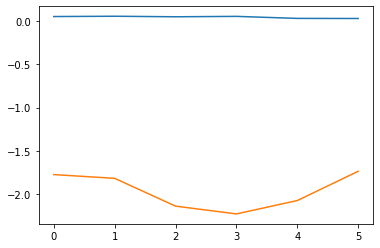

0.33344055944055895 -0.004680807462760381
-0.07091108891108881 -0.006143544880407197


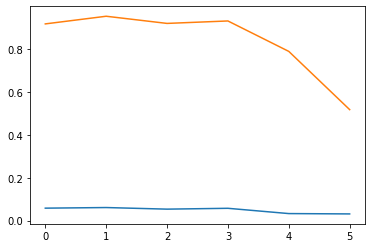

-0.07091108891108881 -0.006181426878486361


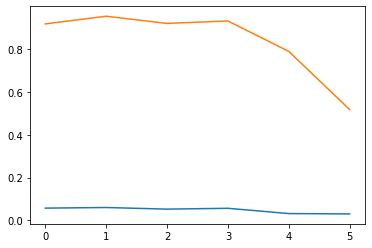

Answers right: 0.49


In [461]:
count = 0
for i in range(0,200):
    y_hat_slope, y_hat_intercept, r, p, std_err = stats.linregress([int(i) for i in range(y_hat.shape[1])], y_hat_inverse[i])
    Y_test_slope, Y_test_intercept, r, p, std_err = stats.linregress([int(i) for i in range(Y_test.shape[1])], y_test_inverse[i])
    
#     print(Y_test_slope, y_hat_slope)
    print(Y_test_slope, y_hat_slope)
    delta = Y_test_slope-y_hat_slope
    if(y_hat_slope > 0 and Y_test_slope > 0 or (y_hat_slope < 0 and Y_test_slope < 0)):
        count+=1
        plt.plot(y_hat_inverse[i])
        plt.plot(y_test_inverse[i])

        plt.show()
#     if(delta < 0.025 and delta > -0.025):
#         count+=1
#         plt.plot(y_hat_inverse[i])
#         plt.plot(y_test_inverse[i])

#         plt.show()
        
print(f"Answers right: {count/200}")

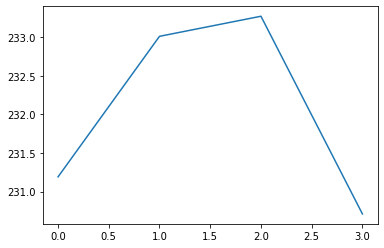

In [321]:
plt.plot(y_test[0])

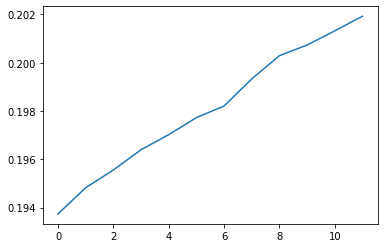

In [212]:
plt.plot(Y_test[2])

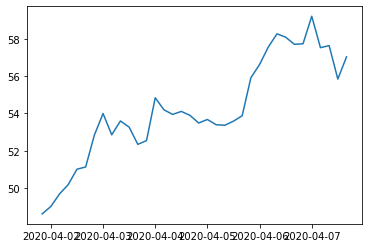

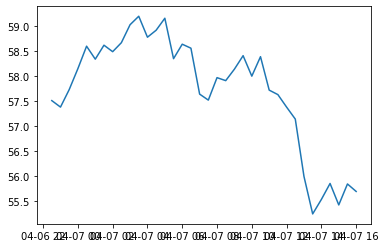

In [54]:
plt.plot(hour4Candles.close)
plt.show()

plt.plot(minute30Candles.close)
plt.show()

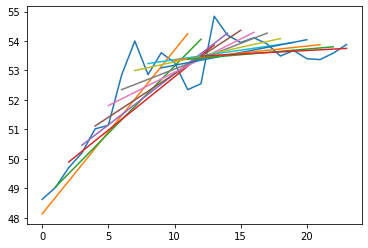

In [55]:
"""
    The slopes of the 24 candle window
"""

WINDOW = 24
SLIDING_WINDOW = 12

new_data = hour4Candles
new_data.head()

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW)], new_data.close[0:WINDOW])

for index in range(WINDOW-SLIDING_WINDOW+1):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(new_data.slope[index+SLIDING_WINDOW - 1]*i)+new_data.intercept[index+SLIDING_WINDOW - 1] for i in range(SLIDING_WINDOW)])

2020-04-05 20:00:00   -0.024056
2020-04-06 00:00:00    0.004755
2020-04-06 04:00:00    0.141469
2020-04-06 08:00:00    0.272413
2020-04-06 12:00:00    0.395874
2020-04-06 16:00:00    0.489545
2020-04-06 20:00:00    0.531294
2020-04-07 00:00:00    0.528986
2020-04-07 04:00:00    0.562203
2020-04-07 08:00:00    0.479476
2020-04-07 12:00:00    0.370804
2020-04-07 16:00:00    0.173497
Name: slope, dtype: float64


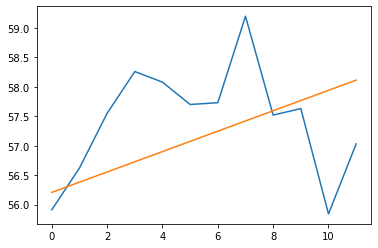

In [59]:
"""
    FOR PREDICTION
    The slope of the chart, 12 candles outside the window
"""
WINDOW_START = 24
WINDOW_END = 36
SLIDING_WINDOW = 12

new_data = hour4Candles
new_data.head()


print(new_data.slope[WINDOW_START:WINDOW_END])

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW_END-WINDOW_START)], new_data.close[WINDOW_START:WINDOW_END])

plt.plot([i for i in range(0,WINDOW_END-WINDOW_START)], [(new_data.slope[WINDOW_START+SLIDING_WINDOW-1]*i)+new_data.intercept[WINDOW_START+SLIDING_WINDOW-1] for i in range(SLIDING_WINDOW)])

plt.show()
    
    

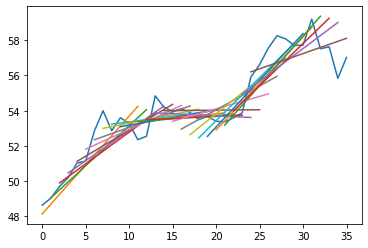

In [57]:
"""
    All slopes on chart
"""

WINDOW = 36
SLIDING_WINDOW = 12

new_data = hour4Candles
new_data.head()

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW)], new_data.close[0:WINDOW])

for index in range(WINDOW-SLIDING_WINDOW+1):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(new_data.slope[index+SLIDING_WINDOW - 1]*i)+new_data.intercept[index+SLIDING_WINDOW - 1] for i in range(SLIDING_WINDOW)])

In [18]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9


0


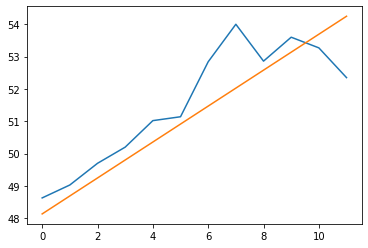

1


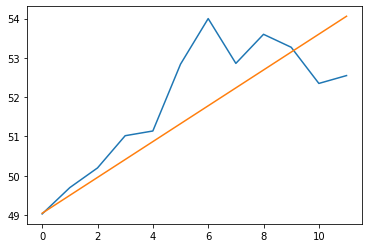

2


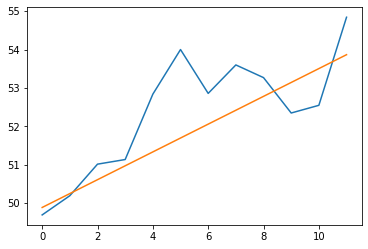

3


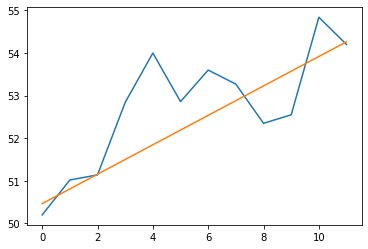

4


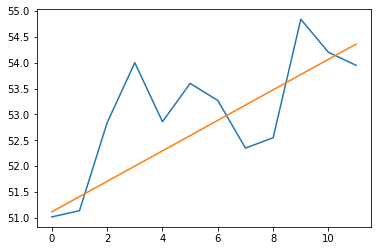

5


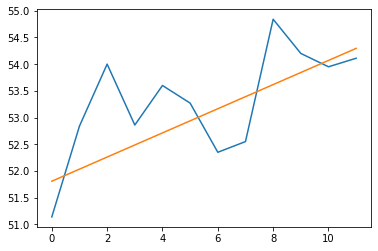

6


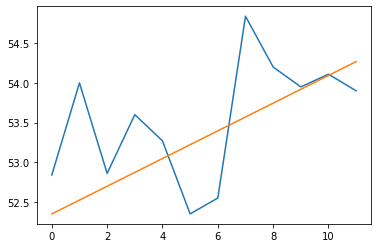

7


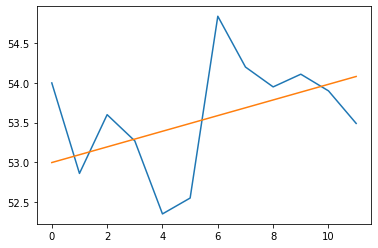

8


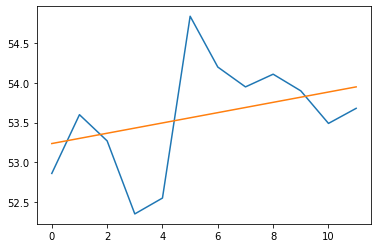

9


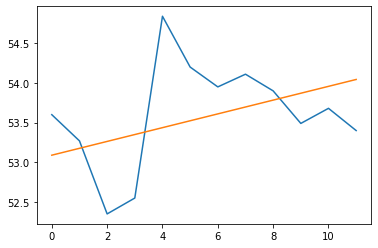

10


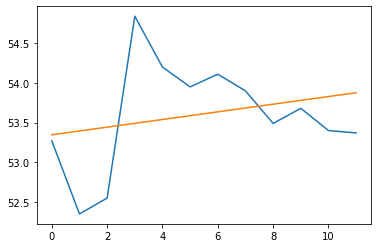

11


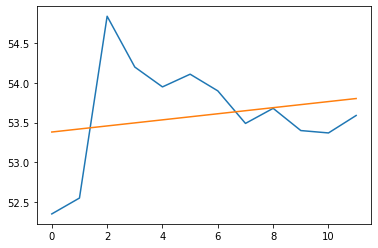

12


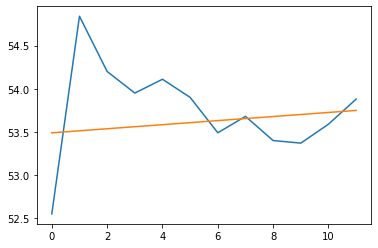

13


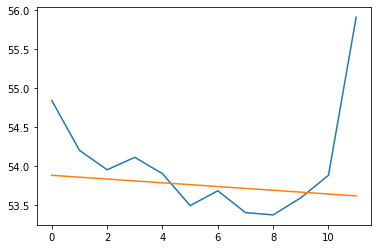

14


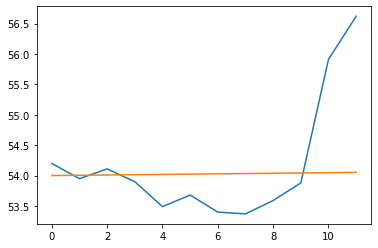

15


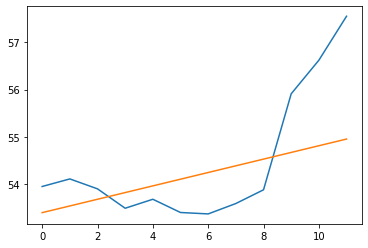

16


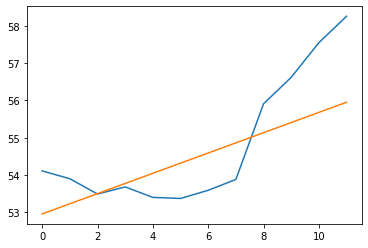

17


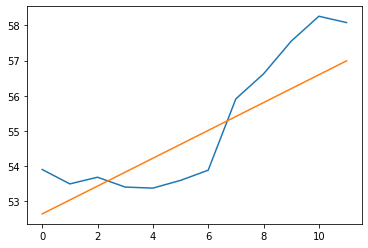

18


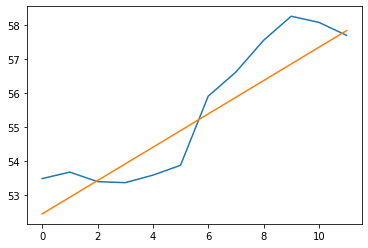

19


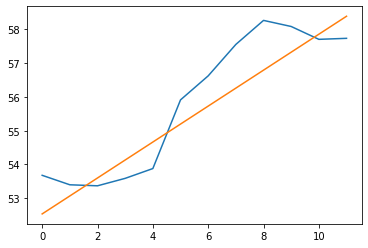

20


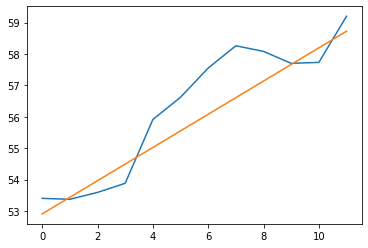

21


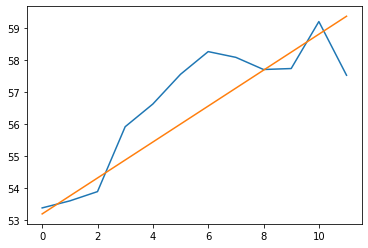

22


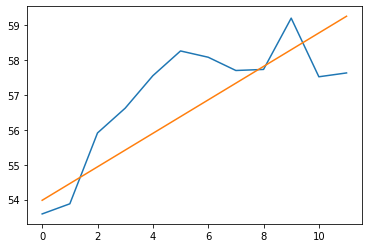

23


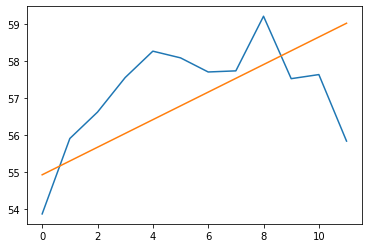

24


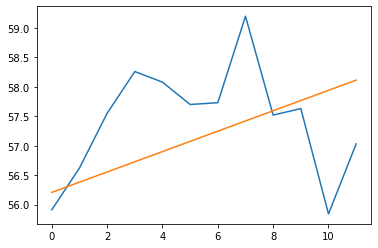

In [72]:


for index in range(0,25):
    print(index)
    plt.plot([i for i in range(0,12)], new_data.close[index:index+SLIDING_WINDOW])
    plt.plot([i for i in range(0,12)], [(new_data.slope[index+SLIDING_WINDOW-1]*i)+new_data.intercept[index+SLIDING_WINDOW-1] for i in range(SLIDING_WINDOW)])
    plt.show()

compile time type static dispatch uses static type


run time type dynamic dispatch uses dynamic type

virtual function uses dynamic dispatch
non-virtual functio uses static dispatch

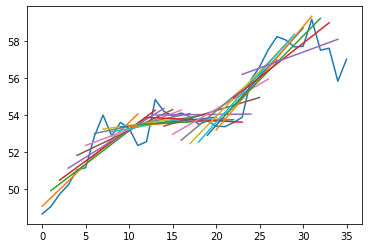

In [13]:
WINDOW = 36
SLIDING_WINDOW = 12

new_data = hour4Candles
new_data.head()

slopes = []
for i in range(SLIDING_WINDOW, WINDOW):
    market_close_data = new_data.close[i-SLIDING_WINDOW:i]
    result = stats.linregress([int(i) for i in range(SLIDING_WINDOW)], market_close_data)
    slopes.append((result.slope, result.intercept))
    

plt.plot([i for i in range(0,36)], new_data.close[0:36])

for index in range(24):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(slopes[index][0]*i)+slopes[index][1] for i in range(SLIDING_WINDOW)])

In [75]:
np.array([hour4Candles.slope.to_numpy(), minute30Candles.slope.to_numpy()])

array([[ 0.02101399,  0.08202797,  0.14153846,  0.19975524,  0.2698951 ,
         0.37706294,  0.42622378,  0.51153846,  0.60216783,  0.60590909,
         0.57940559,  0.55573427,  0.45566434,  0.36111888,  0.34541958,
         0.29493007,  0.22608392,  0.17444056,  0.09856643,  0.0648951 ,
         0.08671329,  0.04818182,  0.03835664,  0.0236014 , -0.02405594,
         0.00475524,  0.14146853,  0.27241259,  0.39587413,  0.48954545,
         0.53129371,  0.52898601,  0.5622028 ,  0.47947552,  0.3708042 ,
         0.1734965 ],
       [-0.23534965, -0.23073427, -0.16527972, -0.11237762, -0.01741259,
         0.05482517,  0.08353147,  0.11814685,  0.12314685,  0.14993007,
         0.16227273,  0.16055944,  0.14685315,  0.1284965 ,  0.1036014 ,
         0.05101399,  0.02433566,  0.01160839, -0.04804196, -0.09468531,
        -0.12223776, -0.14027972, -0.1277972 , -0.09097902, -0.0834965 ,
        -0.0491958 , -0.02604895, -0.03311189, -0.03157343, -0.03409091,
        -0.11272727, -0.21412

### new_data2 = calculate_slopes(m30, 12)
new_data2.head()

WINDOW = 36
SLIDING_WINDOW = 12

slopes = []
for i in range(SLIDING_WINDOW, WINDOW):
    market_close_data = new_data2.close[i-SLIDING_WINDOW:i]
    result = stats.linregress([int(i) for i in range(SLIDING_WINDOW)], market_close_data)
    slopes.append((result.slope, result.intercept))
#     plt.plot([i for i in range(SLIDING_WINDOW)],market_close_data)
#     plt.plot([i for i in range(SLIDING_WINDOW)], [(result.slope*i)+result.intercept for i in range(SLIDING_WINDOW)])
#     plt.show()
    
    
plt.plot([i for i in range(0,36)], new_data2.close[0:36])

for index in range(24):
    plt.plot([i for i in range(index,12+index)], [(slopes[index][0]*i)+slopes[index][1] for i in range(12)])